# Kickstarter Projects

In [26]:
#change display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [159]:
#suppress warnings
import warnings
warnings.simplefilter(action='ignore')

Can we predict which Kickstarter projects will be successful?

## Data Cleaning and Exploration

In [160]:
#import pandas, matplotlib, seaborn, other packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import scipy.stats as scs
from mpl_toolkits.mplot3d import Axes3D

In [161]:
#change the float display for when using .describe()
pd.options.display.float_format = "{:.2f}".format

In [162]:
#read in and preview file
#download path https://www.kaggle.com/toshimelonhead/400000-kickstarter-projects
file_path = 'kickstarter.csv'

data = pd.read_csv(file_path, index_col = 'Unnamed: 0')

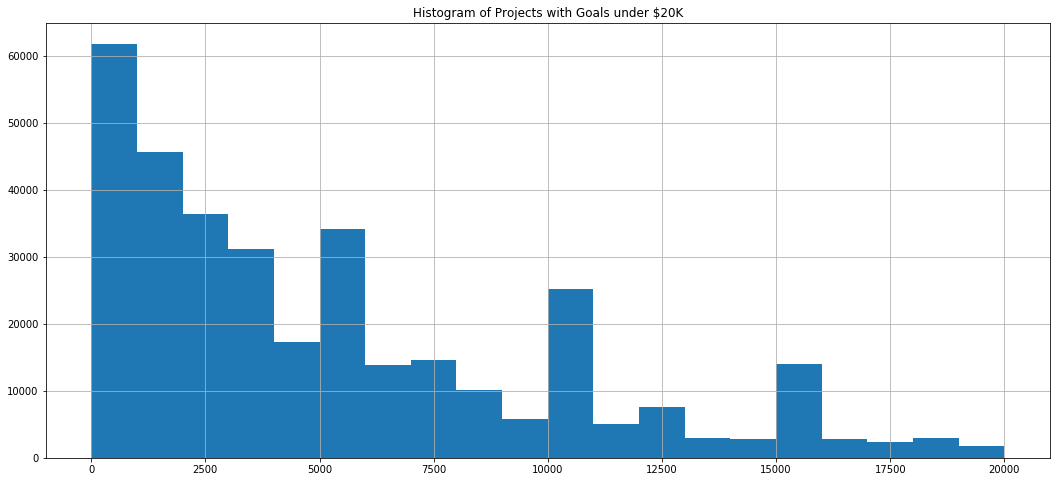

In [163]:
#attempt to understand goal_USD data shape by only looking at data under 20k
data['goal_USD'].loc[data['goal_USD'] < 20000].hist(bins = 20, figsize=(18,8))
plt.title('Histogram of Projects with Goals under $20K')
plt.show()

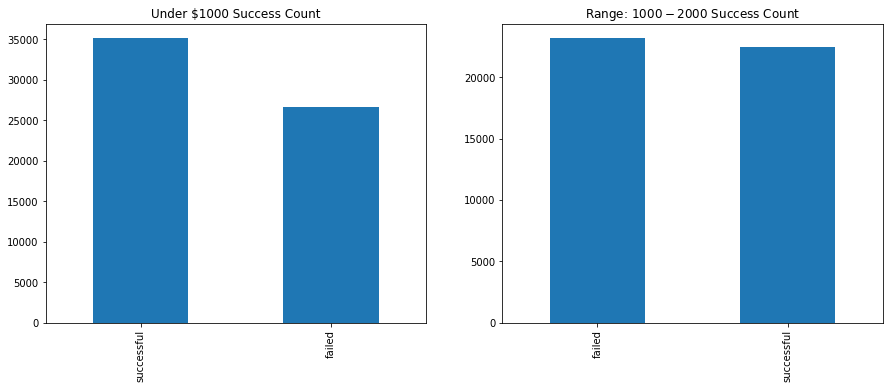

In [164]:
#Checking first 1000 category against 2nd 1000. Already by the second, failure is more likely than success.
fig=plt.figure(figsize=(15,5.5))
plt.subplot(1,2,1)
plt.title('Under $1000 Success Count')
data['binary_state'].loc[data['goal_USD'] < 1000].value_counts().plot(kind='bar')
plt.subplot(1,2,2)
plt.title("Range: $1000 - $2000 Success Count")
data['binary_state'].loc[(data['goal_USD'] >= 1000) & (data['goal_USD'] < 2000)].value_counts().plot(kind='bar')
plt.show()


I decided to throw out data with a goal under $1000 as they do not seem to be "serious" crowdfunding projects.

In [165]:
#throwing data with a goal under 1000
cleaned_data = data.loc[data['goal_USD'] >= 1000]
#removing data from memory
del data

In [166]:
#print out approximate time when data was captured
print(cleaned_data['launched_at'].max())
#filter out data where target date is beyond the date of the data
cleaned_data = cleaned_data.loc[cleaned_data['deadline'] <= cleaned_data['launched_at'].max()]

2019-04-18 04:49:38


I threw out data where the deadline is beyond the cutoff date

## Is ID an appropriate Index?

In [167]:
#is ID an appropriate index?
print('The total number of rows is ' + str(len(cleaned_data)) + '.')
print('The number of unique IDs is ' + str(cleaned_data.id.nunique()) + '.')

The total number of rows is 365236.
The number of unique IDs is 267679.


The same projects are captured at different points in time, I will remove duplicate ID lines taking information from the most recent information (highest USD pledged)

In [168]:
#dropping duplicates, note sorting by usd pledged so I only keep the most recent data (unlikely pledged amount goes down)
cleaned_data = cleaned_data.sort_values('usd_pledged', ascending = False).drop_duplicates(subset = 'id', keep = 'first')
cleaned_data.id.describe()

count       267679.00
mean    1073459652.11
std      619440051.22
min           8624.00
25%      536011791.50
50%     1075032467.00
75%     1608601833.00
max     2147476221.00
Name: id, dtype: float64

ID is now a unique column, so it can be set as the index

In [169]:
#drop old index and replace with ID column
cleaned_data = cleaned_data.reset_index(drop=True).set_index('id').sort_index()

## Date Time Columns

In [170]:
#convert the date columns to datetime
cleaned_data['launched_at'] = pd.to_datetime(cleaned_data['launched_at'])
cleaned_data['deadline'] = pd.to_datetime(cleaned_data['deadline'])

#create a new column for days between launch and goal date
cleaned_data['days_between'] = (cleaned_data['deadline'] - cleaned_data['launched_at']).dt.days

## Creating Additional Columns (Preliminary Feature Engineering)

In [171]:
#strip out city name
cleaned_data['city'] = [i.split(', ')[0] for i in cleaned_data['location_displayable_name']]
cleaned_data.city.head()

id
8624         Belgium
18520      Cleveland
24380    Bloomington
33867      Vancouver
38736        Livonia
Name: city, dtype: object

In [172]:
#create a proportion of goal column
cleaned_data['prop_goal'] = cleaned_data['usd_pledged'] / cleaned_data['goal_USD']
cleaned_data.prop_goal.head()

id
8624    2.52
18520   0.00
24380   0.04
33867   0.16
38736   0.04
Name: prop_goal, dtype: float64

In [173]:
#number of characters in blurb
cleaned_data['blurb_char_length'] = [len(str(i).strip(' ')) for i in cleaned_data.blurb]
cleaned_data.blurb_char_length.head()

id
8624      69
18520    135
24380    133
33867    134
38736    117
Name: blurb_char_length, dtype: int64

In [174]:
#ratio of character length divided by word length
cleaned_data['blurb_char_per_word'] = cleaned_data.blurb_char_length / cleaned_data.blurb_length
cleaned_data.blurb_char_per_word.head()

id
8624    5.75
18520   5.62
24380   5.54
33867   5.83
38736   5.57
Name: blurb_char_per_word, dtype: float64

In [175]:
#count the length of the name
cleaned_data['name_length'] = [len(str(i).split()) for i in cleaned_data.name]
cleaned_data.name_length.head()

id
8624     10
18520     3
24380     9
33867     5
38736     2
Name: name_length, dtype: int64

In [176]:
#length of name in characters excluding spaces
cleaned_data['name_char_length'] = [len(str(i).strip(' ')) for i in cleaned_data.name]
cleaned_data.name_char_length.head()

id
8624     60
18520    18
24380    49
33867    23
38736    11
Name: name_char_length, dtype: int64

In [177]:
#ratio of character length divided by word length
cleaned_data['name_char_per_word'] = cleaned_data.name_char_length / cleaned_data.name_length
cleaned_data.name_char_per_word.head()

id
8624    6.00
18520   6.00
24380   5.44
33867   4.60
38736   5.50
Name: name_char_per_word, dtype: float64

In [178]:
#convert success to boolean
d = {'successful' : 1, 'failed' : 0}
cleaned_data.binary_state = cleaned_data.binary_state.map(d)

## Looking at Content in Text Columns (Feature Engineering)

In [179]:
#creating count function
count = lambda l1,l2: sum([1 for x in l1 if x in l2])
#applying count to name text punctuation
cleaned_data['name_punct_count'] = [count(str(i), set(string.punctuation)) for i in cleaned_data.name]
cleaned_data.name_punct_count.head()

id
8624     2
18520    1
24380    3
33867    0
38736    0
Name: name_punct_count, dtype: int64

In [180]:
cleaned_data['blurb_punct_count'] = [count(str(i), set(string.punctuation)) for i in cleaned_data.blurb]
cleaned_data.blurb_punct_count.head()

id
8624     1
18520    3
24380    2
33867    4
38736    3
Name: blurb_punct_count, dtype: int64

In [181]:
#looking for help as the first word in the blurb
cleaned_data['help_first_blurb'] = [('help' == str(i)[0:4].lower()) for i in cleaned_data.blurb]
print(cleaned_data.help_first_blurb.value_counts())
print((cleaned_data['help_first_blurb'].loc[cleaned_data['binary_state'] == 1].value_counts())/(cleaned_data['help_first_blurb'].value_counts()))

False    260978
True       6701
Name: help_first_blurb, dtype: int64
False   0.43
True    0.56
Name: help_first_blurb, dtype: float64


Highlighting the purpose of helping someone is helpful for success.

In [182]:
#check if the first word of the blurb or name is lowercase
def lowercase_first(row):
    y = ((str(row['blurb'])[0:2].islower()) and (str(row['blurb'])[0:2].isalpha()) or ((str(row['name'])[0:2].islower()) and (str(row['name'])[0:2].isalpha())))
    return y

cleaned_data['lowercase_first'] = cleaned_data.apply(lowercase_first, axis=1)

print(cleaned_data.lowercase_first.value_counts())
print((cleaned_data['lowercase_first'].loc[cleaned_data['binary_state'] == 1].value_counts())/(cleaned_data['lowercase_first'].value_counts()))

False    261795
True       5884
Name: lowercase_first, dtype: int64
False   0.44
True    0.30
Name: lowercase_first, dtype: float64


Lack of capitalization might indicate informality or lack of attention to detail.

In [183]:
#check if the the first word of the name is all capitalized
cleaned_data['first_name_cap'] = [(str(i)[0:2].isupper()) and (str(i)[0:2].isalpha()) for i in cleaned_data.name]
print(cleaned_data.first_name_cap.value_counts())
print((cleaned_data['first_name_cap'].loc[cleaned_data['binary_state'] == 1].value_counts())/(cleaned_data['first_name_cap'].value_counts()))

#check if the the first word of the blurb is capitalized wasn't as impactful

False    236085
True      31594
Name: first_name_cap, dtype: int64
False   0.43
True    0.49
Name: first_name_cap, dtype: float64


Those projects capitalizing the first word of the name had a slightly higher probability of success.

In [184]:
#does the blurb contain an exclamation point? Does the name?

def exclam_first(row):
    y = ("!" in str(row['blurb']) or "!" in str(row['name']))
    return y

cleaned_data['exclam'] = cleaned_data.apply(exclam_first, axis=1)

print(cleaned_data.exclam.value_counts())
print((cleaned_data['exclam'].loc[cleaned_data['binary_state'] == 1].value_counts())/(cleaned_data['exclam'].value_counts()))


False    195799
True      71880
Name: exclam, dtype: int64
False   0.42
True    0.48
Name: exclam, dtype: float64


## Dropping Unnecessary Columns

In [185]:
# dropping the location.country column (already location_country column); 
# the days to deadline not useful as the deadline should be passed;
# the state column is not necessary with the binary_state column; and the individual date columns are not necessary
# the spotlight and staff pick columns can be dropped
# dropping a few additional columns I don't plan to use

cleaned_data = cleaned_data.drop(columns=['location.country', 'days_to_deadline', 'state', 
                                 'year', 'month', 'day', 'hour', 'spotlight', 'staff_pick', 'location_displayable_name', 'slug'])

In [186]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267679 entries, 8624 to 2147476221
Data columns (total 31 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   backers_count        267679 non-null  int64         
 1   blurb                267679 non-null  object        
 2   currency             267679 non-null  object        
 3   goal                 267679 non-null  float64       
 4   launched_at          267679 non-null  datetime64[ns]
 5   deadline             267679 non-null  datetime64[ns]
 6   name                 267676 non-null  object        
 7   usd_pledged          267679 non-null  float64       
 8   static_usd_rate      267679 non-null  float64       
 9   goal_USD             267679 non-null  float64       
 10  category_name        267679 non-null  object        
 11  category_slug        267679 non-null  object        
 12  blurb_length         267679 non-null  int64         
 13  locatio

## Data Visualization

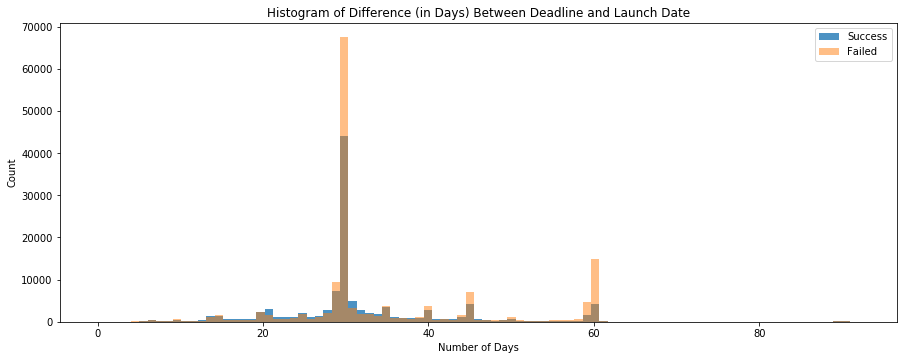

Success Descriptive Statistics
count   116077.00
mean        32.57
std         11.20
min          1.00
25%         29.00
50%         30.00
75%         34.00
max         91.00
Name: days_between, dtype: float64

Failed Descriptive Statistics
count   151602.00
mean        35.48
std         12.63
min          1.00
25%         30.00
50%         30.00
75%         40.00
max         92.00
Name: days_between, dtype: float64


In [193]:
#histogram of days between
f, ax=plt.subplots(figsize=(15,5.5))
x = cleaned_data['days_between'].loc[cleaned_data['binary_state'] == True]
y = cleaned_data['days_between'].loc[cleaned_data['binary_state'] == False]
bins = np.linspace(0, 92, 92)

plt.hist(x, bins, alpha=0.8, label='Success')
plt.hist(y, bins, alpha=0.5, label='Failed')
plt.legend(loc='upper right')
ax.set(ylabel="Count", xlabel = "Number of Days", title = 'Histogram of Difference (in Days) Between Deadline and Launch Date')
plt.show()

print('\033[1m' + "Success Descriptive Statistics" + '\033[0m')
print(x.describe())
print('')
print('\033[1m' + "Failed Descriptive Statistics" + '\033[0m')
print(y.describe())

Most Kickstarters have the deadline set at around 30 days from the launch date.

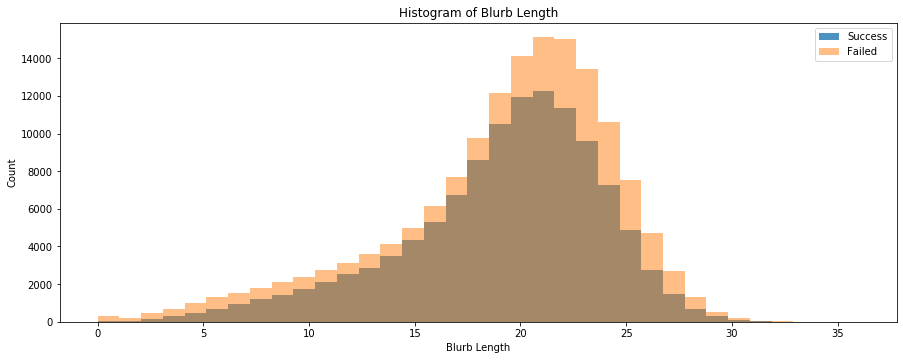

Success Descriptive Statistics
count   116077.00
mean        19.11
std          4.65
min          1.00
25%         17.00
50%         20.00
75%         22.00
max         35.00
Name: blurb_length, dtype: float64

Failed Descriptive Statistics
count   151602.00
mean        19.19
std          5.13
min          1.00
25%         17.00
50%         20.00
75%         23.00
max         36.00
Name: blurb_length, dtype: float64


In [192]:
f, ax =plt.subplots(figsize=(15,5.5))
x = cleaned_data['blurb_length'].loc[cleaned_data['binary_state'] == True]
y = cleaned_data['blurb_length'].loc[cleaned_data['binary_state'] == False]
bins = np.linspace(0, 36, 36)

plt.hist(x, bins=bins, alpha=0.8, label='Success')
plt.hist(y, bins=bins, alpha=0.5, label='Failed')
plt.legend(loc='upper right')
ax.set(ylabel="Count", xlabel = "Blurb Length", title = 'Histogram of Blurb Length')
plt.show()
print('\033[1m' + "Success Descriptive Statistics" + '\033[0m')
print(x.describe())
print('')
print('\033[1m' + "Failed Descriptive Statistics" + '\033[0m')
print(y.describe())

Both successful and unsuccessful projects have a similar blurb length distribution

In [ ]:
#bootstrap statistics on the mean of blurb length, CAREFUL OF CALC TIME
#see x and y from above
N_rep = 5000
success_blurb_length_mean = np.empty(N_rep)
failed_blurb_length_mean = np.empty(N_rep)

for i in range(N_rep):
    success_blurb_length_mean[i] = np.mean(np.random.choice(x, size=len(x)))
    failed_blurb_length_mean[i] = np.mean(np.random.choice(y, size=len(y)))
    
mean_diff_blurb = failed_blurb_length_mean - success_blurb_length_mean

In [ ]:
p_value = np.sum(mean_diff_blurb < 0) / N_rep
print(p_value)

We can conclude that it is very likely that the failed blurb length has a larger mean than the successful blurb length despite the small difference.

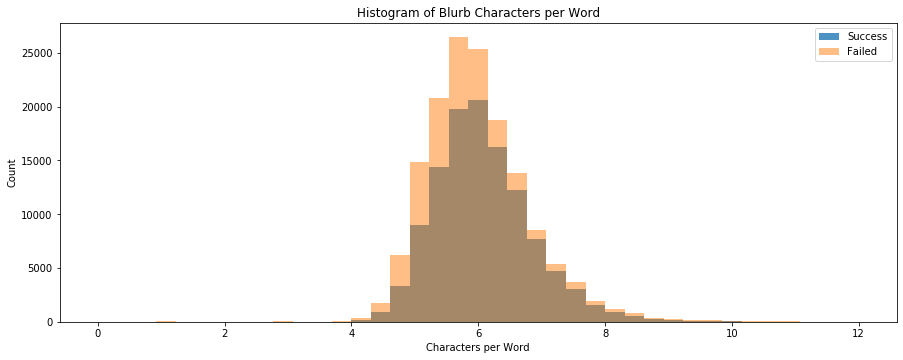

Success Descriptive Statistics
count   116077.00
mean         6.10
std          1.40
min          1.00
25%          5.55
50%          6.00
75%          6.53
max        189.00
Name: blurb_char_per_word, dtype: float64

Failed Descriptive Statistics
count   151602.00
mean         6.04
std          2.14
min          1.00
25%          5.44
50%          5.90
75%          6.44
max        369.00
Name: blurb_char_per_word, dtype: float64


In [191]:
f, ax=plt.subplots(figsize=(15,5.5))
x = cleaned_data['blurb_char_per_word'].loc[cleaned_data['binary_state'] == True]
y = cleaned_data['blurb_char_per_word'].loc[cleaned_data['binary_state'] == False]
bins = np.linspace(0, 12, 40)

plt.hist(x, bins = bins, alpha=0.8, label='Success')
plt.hist(y, bins = bins, alpha=0.5, label='Failed')
plt.legend(loc='upper right')
ax.set(ylabel="Count", xlabel = "Characters per Word", title = 'Histogram of Blurb Characters per Word')
plt.show()
print('\033[1m' + "Success Descriptive Statistics" + '\033[0m')
print(x.describe())
print('')
print('\033[1m' + "Failed Descriptive Statistics" + '\033[0m')
print(y.describe())

The failed histogram is shifted slightly to the left and has a lot more outliers to the left than the successful population.

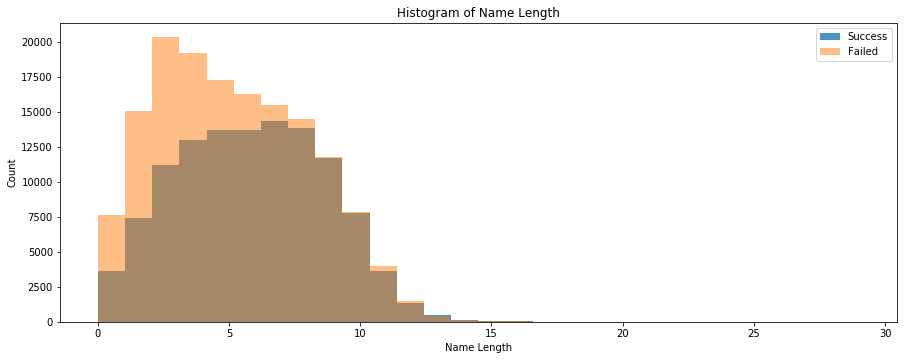

Success Descriptive Statistics
count   116077.00
mean         6.16
std          2.72
min          1.00
25%          4.00
50%          6.00
75%          8.00
max         27.00
Name: name_length, dtype: float64

Failed Descriptive Statistics
count   151602.00
mean         5.53
std          2.78
min          1.00
25%          3.00
50%          5.00
75%          8.00
max         29.00
Name: name_length, dtype: float64


In [190]:
f, ax=plt.subplots(figsize=(15,5.5))
x = cleaned_data['name_length'].loc[cleaned_data['binary_state'] == True]
y = cleaned_data['name_length'].loc[cleaned_data['binary_state'] == False]
bins = np.linspace(0, 29, 29)
plt.hist(x, bins=bins, alpha=0.8, label='Success')
plt.hist(y, bins=bins, alpha=0.5, label='Failed')
plt.legend(loc='upper right')
ax.set(ylabel="Count", xlabel = "Name Length", title = 'Histogram of Name Length')
plt.show()
print('\033[1m' + "Success Descriptive Statistics" + '\033[0m')
print(x.describe())
print('')
print('\033[1m' + "Failed Descriptive Statistics" + '\033[0m')
print(y.describe())

Longer blurbs were more likely to be successful on average. There is a high concentration of failures in the 1-4 name length range compared with the more uniform distribution of successes.

In [59]:
#bootstrap statistics on the mean of name length, CAREFUL OF CALC TIME
#see x and y from above
N_rep = 5000
success_name_length_mean = np.empty(N_rep)
failed_name_length_mean = np.empty(N_rep)

for i in range(N_rep):
    success_name_length_mean[i] = np.mean(np.random.choice(x, size=len(x)))
    failed_name_length_mean[i] = np.mean(np.random.choice(y, size=len(y)))
    
mean_diff_name = success_name_length_mean - failed_name_length_mean

In [60]:
p_value = np.sum(mean_diff_name < 0) / N_rep
print(p_value)

0.0


We can conclude that it is very likely that the successful name length has a larger mean than the failed name length.

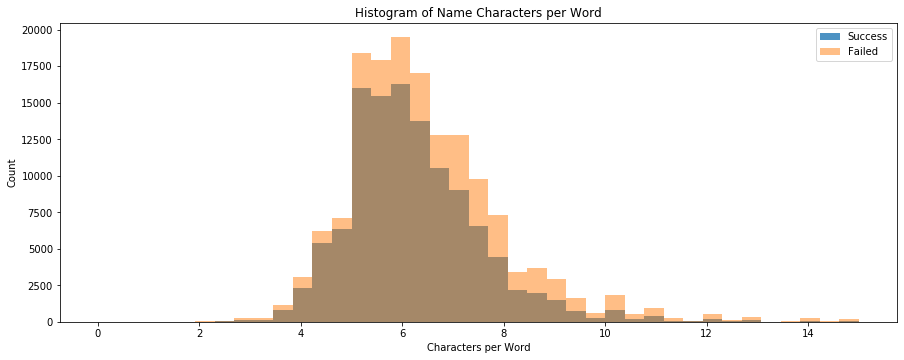

Success Descriptive Statistics
count   116077.00
mean         6.22
std          1.40
min          1.67
25%          5.33
50%          6.00
75%          6.88
max         60.00
Name: name_char_per_word, dtype: float64

Failed Descriptive Statistics
count   151602.00
mean         6.49
std          1.81
min          1.00
25%          5.43
50%          6.20
75%          7.20
max        108.00
Name: name_char_per_word, dtype: float64


In [189]:
f, ax =plt.subplots(figsize=(15,5.5))
x = cleaned_data['name_char_per_word'].loc[cleaned_data['binary_state'] == True]
y = cleaned_data['name_char_per_word'].loc[cleaned_data['binary_state'] == False]
bins = np.linspace(0, 15, 40)

plt.hist(x, bins = bins, alpha=0.8, label='Success')
plt.hist(y, bins = bins, alpha=0.5, label='Failed')
plt.legend(loc='upper right')
ax.set(ylabel="Count", xlabel = "Characters per Word", title = 'Histogram of Name Characters per Word')
plt.show()
print('\033[1m' + "Success Descriptive Statistics" + '\033[0m')
print(x.describe())
print('')
print('\033[1m' + "Failed Descriptive Statistics" + '\033[0m')
print(y.describe())

The distribution of failures is slightly more skewed to the right than the successes.

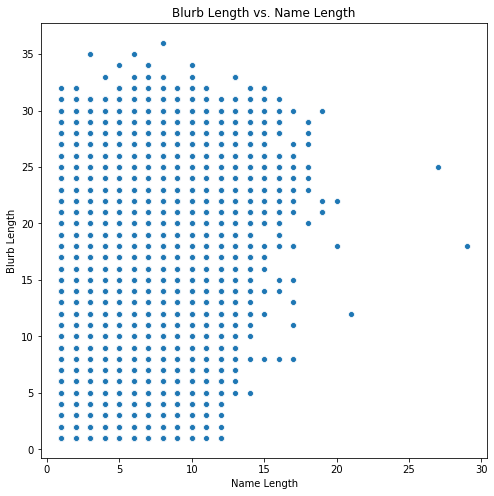

In [34]:
#plotting name length against blurb length
f, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x='name_length', y='blurb_length', data=cleaned_data, palette = 'muted')
ax.set(ylabel="Blurb Length", xlabel = "Name Length", title = 'Blurb Length vs. Name Length')
plt.show()

In [35]:
# calculate Pearson's correlation
corr, _ = scs.pearsonr(cleaned_data.name_length, cleaned_data.blurb_length)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.148


The two variables are not highly correlated.

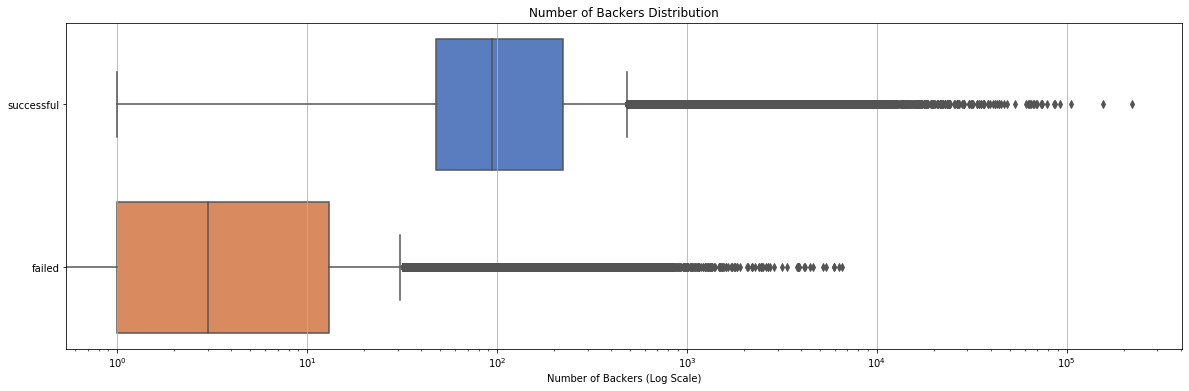

In [194]:
d = {1 : 'successful', 0 : 'failed'}
cleaned_data.binary_state = cleaned_data.binary_state.map(d)
#looking distribution of the backers_count column
f, ax = plt.subplots(figsize=(20, 6))
ax.set_xscale("log")
sns.boxplot(x="backers_count", y = 'binary_state', data=cleaned_data, palette = 'muted')
ax.xaxis.grid(True)
ax.set(ylabel="", xlabel = "Number of Backers (Log Scale)", title = 'Number of Backers Distribution')
plt.show()

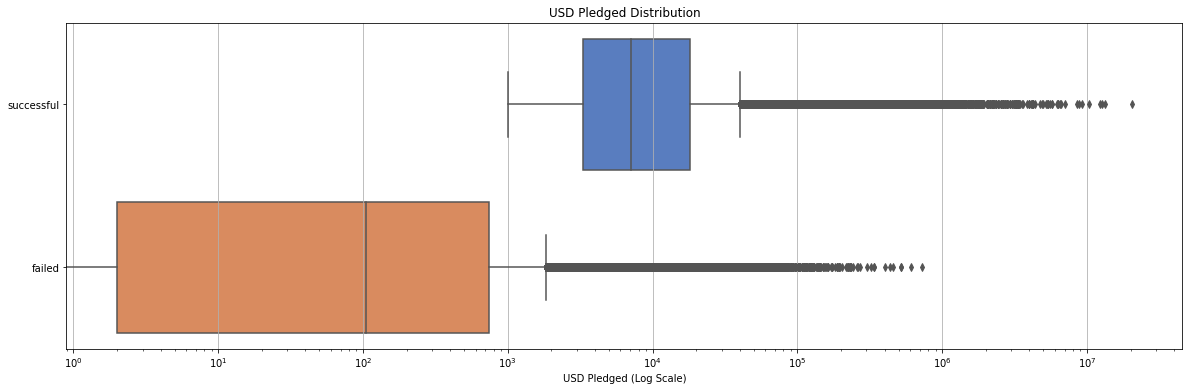

In [195]:
#looking at distribution of USD Pledged
f, ax = plt.subplots(figsize=(20, 6))
ax.set_xscale("log")
sns.boxplot(x="usd_pledged", y= 'binary_state', data=cleaned_data, palette = 'muted')
ax.xaxis.grid(True)
ax.set(ylabel="", xlabel = "USD Pledged (Log Scale)", title = 'USD Pledged Distribution')
plt.show()

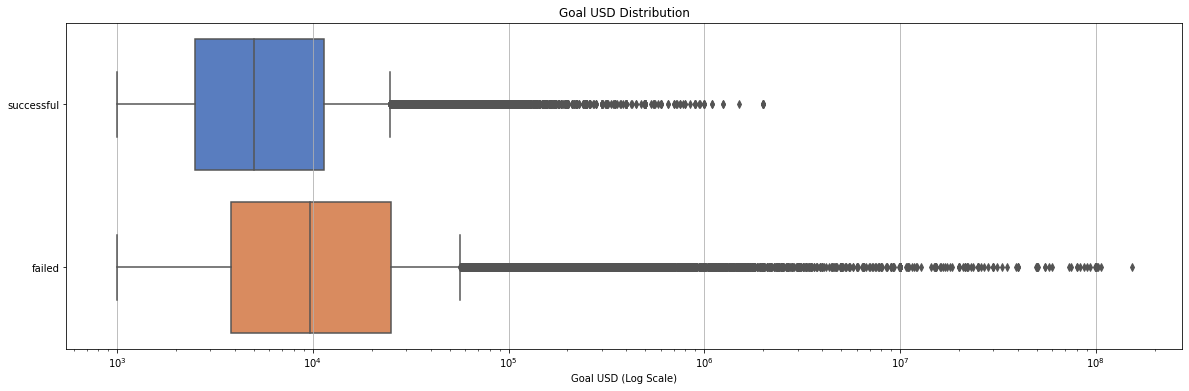

In [196]:
#looking at distribution of USD Goal
f, ax = plt.subplots(figsize=(20, 6))
ax.set_xscale("log")
sns.boxplot(x="goal_USD", y="binary_state", data=cleaned_data, palette = 'muted')
ax.xaxis.grid(True)
ax.set(ylabel="", xlabel = "Goal USD (Log Scale)", title = 'Goal USD Distribution')
plt.show()

count   267679.00
mean         1.03
std          4.86
min          0.00
25%          0.01
50%          0.24
75%          1.11
max        926.57
Name: prop_goal, dtype: float64


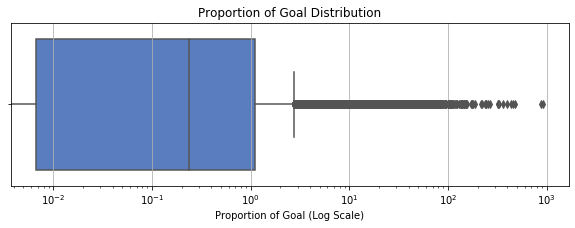

In [197]:
#look at proportion of goal column
print(cleaned_data.prop_goal.describe())

#looking distribution of the prop_goal column
f, ax = plt.subplots(figsize=(10, 3))
ax.set_xscale("log")
sns.boxplot(x="prop_goal", data=cleaned_data, palette = 'muted')
ax.xaxis.grid(True)
ax.set(ylabel="", xlabel = "Proportion of Goal (Log Scale)", title = 'Proportion of Goal Distribution')
plt.show()

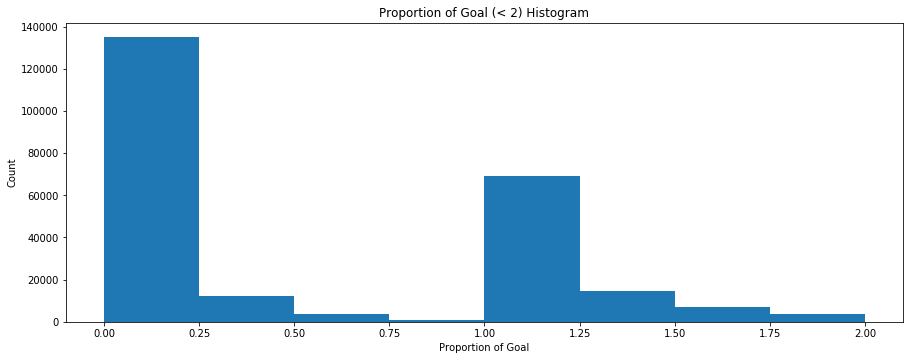

In [198]:
#histogram of Goal Distribution
fig=plt.figure(figsize=(15,5.5))
x = cleaned_data['prop_goal'].loc[cleaned_data['prop_goal'] < 2]
plt.hist(x, bins=8)
plt.xlabel('Proportion of Goal')
plt.ylabel('Count')
plt.title('Proportion of Goal (< 2) Histogram')
plt.show()

Projects usually do not get off the ground, but when they do, they tend to snowball just past the goal and then level off.

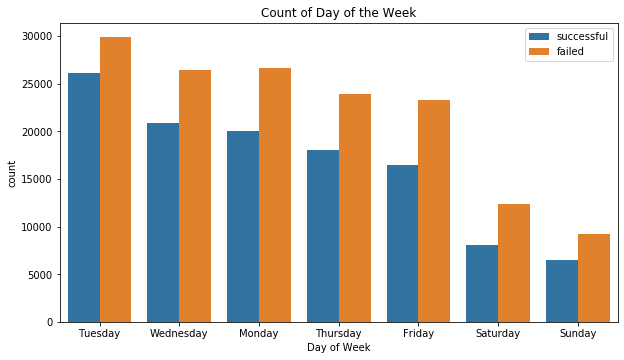

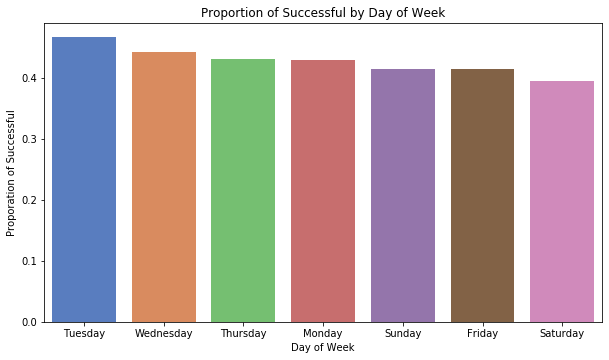

In [199]:
#day of the week bar chart

cleaned_data['day_week'] = cleaned_data['launched_at'].dt.day_name()
fig=plt.figure(figsize=(10,5.5))
chart = sns.countplot(x = 'day_week', hue= 'binary_state', data = cleaned_data, order = cleaned_data['day_week'].value_counts().index)
plt.xlabel('Day of Week')
plt.legend(title = '')
plt.title('Count of Day of the Week')
plt.show()
#probability distribution
y = (cleaned_data['day_week'].loc[cleaned_data['binary_state'] == 'successful'].value_counts())/(cleaned_data['day_week'].value_counts())
y = y.sort_values(ascending=False)
fig=plt.figure(figsize=(10,5.5))
ax = sns.barplot(x = y.index, y = y, palette = 'muted')
plt.xlabel('Day of Week')
plt.ylabel('Proporation of Successful')
plt.title('Proportion of Successful by Day of Week')
plt.show()

The middle of the week is the most popular launch time and has the highest probability of success.

### Chi-squared Test for Categorical Data

In [200]:
# defining a function
from scipy.stats import chi2_contingency

def chisq_of_df_cols(df, c1, c2):
    groupsizes = df.groupby([c1, c2]).size()
    ctsum = groupsizes.unstack(c1)
    # fillna(0) is necessary to remove any NAs which will cause exceptions
    return(chi2_contingency(ctsum.fillna(0)))

In [201]:
#chi squared test for day of week and binary state
chisq_of_df_cols(cleaned_data, 'day_week', 'binary_state')

(481.8272899720435,
 6.899720891982332e-101,
 6,
 array([[22474.76330231, 26445.49549274, 11549.72779336,  8898.60849749,
         23723.58151368, 31729.04428812, 26780.77911229],
        [17208.23669769, 20248.50450726,  8843.27220664,  6813.39150251,
         18164.41848632, 24293.95571188, 20505.22088771]]))

We have sufficient evidence to conclude that the day of the week is not independent of binary state.

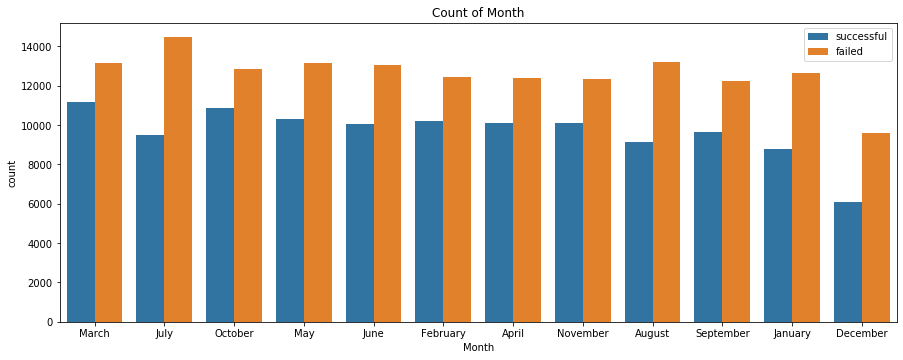

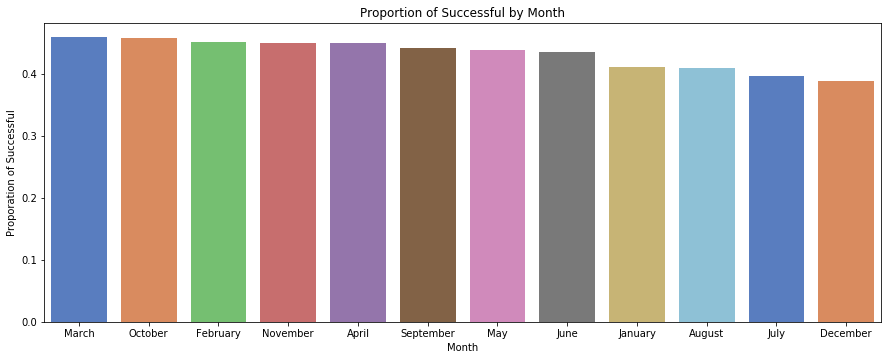

In [202]:
#month of launch count plot
cleaned_data['month'] = cleaned_data['launched_at'].dt.month_name()
fig=plt.figure(figsize=(15,5.5))
chart = sns.countplot(x = 'month', hue = 'binary_state', data = cleaned_data, order = cleaned_data['month'].value_counts().index)
plt.xlabel('Month')
plt.legend(title = '')
plt.title('Count of Month')
plt.show()
y = (cleaned_data['month'].loc[cleaned_data['binary_state'] == 'successful'].value_counts())/(cleaned_data['month'].value_counts())
y = y.sort_values(ascending=False)
fig=plt.figure(figsize=(15,5.5))
ax = sns.barplot(x = y.index, y = y, palette = 'muted')
plt.xlabel('Month')
plt.ylabel('Proporation of Successful')
plt.title('Proportion of Successful by Month')
plt.show()

There was not huge variability between months; however, December has been down months all around.

In [203]:
#chi squared test for day of week and binary state
chisq_of_df_cols(cleaned_data, 'month', 'binary_state')

(576.9576226212162,
 1.184960560184379e-116,
 11,
 array([[12771.36084639, 12644.49677412,  8883.31684592, 12829.12930787,
         12155.73028142, 13586.3492392 , 13094.75095917, 13786.27342451,
         13307.70136619, 12699.43344827, 13427.76914887, 12415.68835807],
        [ 9778.63915361,  9681.50322588,  6801.68315408,  9822.87069213,
          9307.26971858, 10402.6507608 , 10026.24904083, 10555.72657549,
         10189.29863381,  9723.56655173, 10281.23085113,  9506.31164193]]))

We have sufficient evidence to conclude that the month is not independent of binary state.

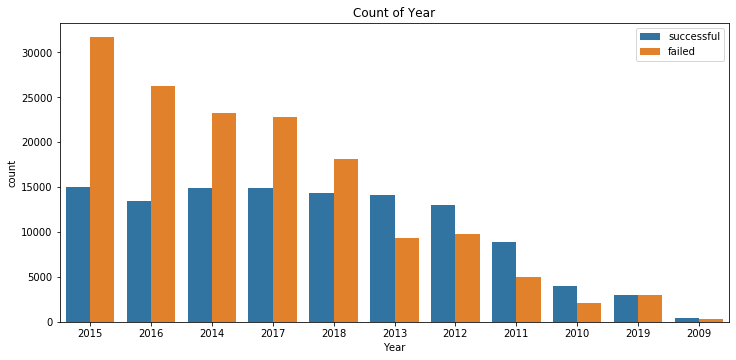

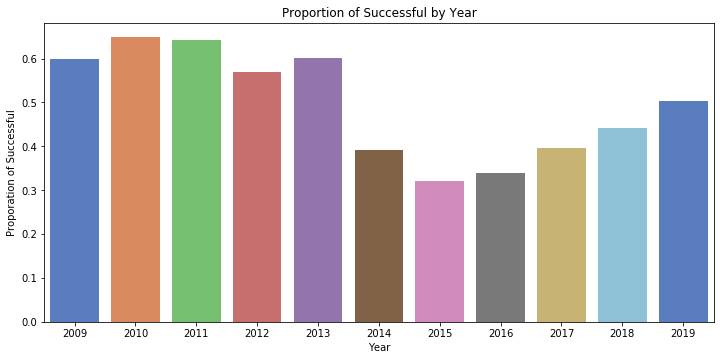

In [204]:
#year of launch count plot
cleaned_data['year'] = cleaned_data['launched_at'].dt.year
fig=plt.figure(figsize=(12,5.5))
chart = sns.countplot(x = 'year', hue = 'binary_state', data = cleaned_data, order = cleaned_data['year'].value_counts().index)
plt.xlabel('Year')
plt.legend(title = '')
plt.title('Count of Year')
plt.show()
y = (cleaned_data['year'].loc[cleaned_data['binary_state'] == 'successful'].value_counts())/(cleaned_data['year'].value_counts())
fig=plt.figure(figsize=(12,5.5))
ax = sns.barplot(x = y.index, y = y, order = y.index, palette = 'muted')
plt.xlabel('Year')
plt.ylabel('Proporation of Successful')
plt.title('Proportion of Successful by Year')
plt.show()

Note that 2019 data is not for a full year. Has the success rate changed in a predicatible pattern?

It appear that the early years were most successful with a large drop in 2014 and then it eventually began to rebound.

**What happened in 2014?**

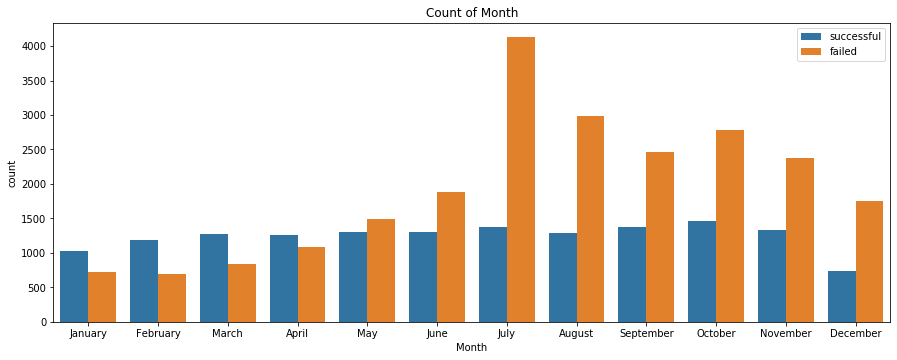

In [205]:
#2014 Launches
fig=plt.figure(figsize=(15,5.5))
chart = sns.countplot(x = 'month', hue = 'binary_state', data = cleaned_data.loc[cleaned_data['year'] == 2014], order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
                                                                                                                        'September', 'October', 'November', 'December'])
plt.xlabel('Month')
plt.legend(title = '')
plt.title('Count of Month')
plt.show()


Activity explodes in July 2014.

In [206]:
#work in progress to figure out what happened in 2014
print('\033[1m' + '2013' + '\033[0m')
print(cleaned_data[['backers_count', 'usd_pledged', 'goal_USD', 'prop_goal']].loc[cleaned_data['year'] == 2013].describe())
print('')
print('\033[1m' + '2014' + '\033[0m')
print(cleaned_data[['backers_count', 'usd_pledged', 'goal_USD', 'prop_goal']].loc[cleaned_data['year'] == 2014].describe())

2013
       backers_count  usd_pledged    goal_USD  prop_goal
count       23493.00     23493.00    23493.00   23493.00
mean          225.91     17235.88    25687.66       1.20
std          1304.08     93558.53   323337.36       2.98
min             0.00         0.00     1000.00       0.00
25%            11.00       535.00     3000.00       0.07
50%            50.00      3365.00     6000.00       1.03
75%           136.00     10360.00    15000.00       1.21
max         91585.00   5702153.38 31424010.40     106.08

2014
       backers_count  usd_pledged     goal_USD  prop_goal
count       38173.00     38173.00     38173.00   38173.00
mean          135.38     11524.35     50608.01       0.83
std           876.57     99827.00   1067704.99       3.44
min             0.00         0.00      1000.00       0.00
25%             2.00        34.07      3000.00       0.00
50%            17.00      1112.54      7500.00       0.14
75%            80.00      6276.00     20000.00       1.08
max        1

In [207]:
print('The total number of backers in 2013 was ' + str(cleaned_data.backers_count.loc[cleaned_data['year'] == 2013].sum()) + '.')
print('')
print('The total number of backers in 2014 was ' + str(cleaned_data.backers_count.loc[cleaned_data['year'] == 2014].sum()) + '.')

The total number of backers in 2013 was 5307192.

The total number of backers in 2014 was 5167952.


**Activity for project creation spiked in 2014, but the number of backers actually decreased. The mean target goal in USD nearly doubled. Success in 2013 was clearly more likely from just this information, but why did this activity spike and why were projects more ambitious in 2014?**

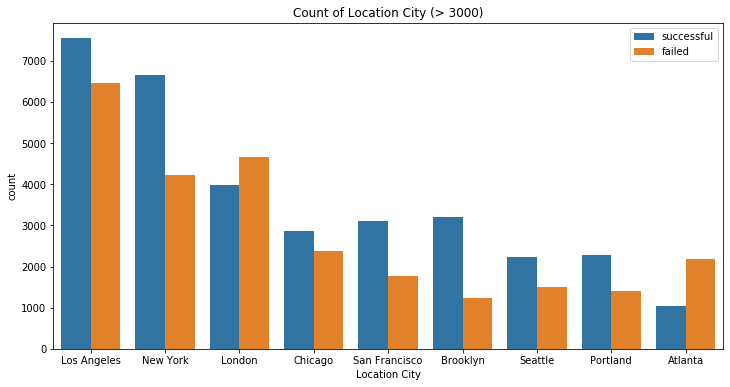

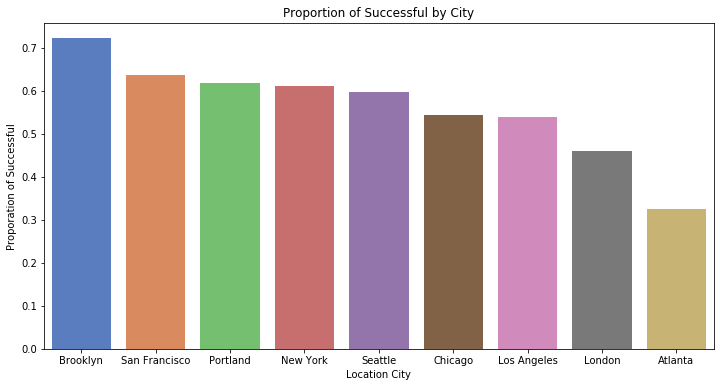

Brooklyn        0.72
San Francisco   0.64
Portland        0.62
New York        0.61
Seattle         0.60
Chicago         0.54
Los Angeles     0.54
London          0.46
Atlanta         0.32
Name: city, dtype: float64


In [208]:
#show the frequency of location city for those with at least 3000 instances
fig = plt.figure(figsize = (12, 6))
sns.countplot(x = 'city', hue = 'binary_state', 
              data = cleaned_data,
              order = cleaned_data.city.value_counts().head(9).index)
plt.legend(title ='')
plt.xlabel('Location City')
plt.title('Count of Location City (> 3000)')
plt.show()
# make this into a probability distribution like above
y = (cleaned_data['city'].loc[cleaned_data['city'].isin(cleaned_data.city.value_counts().head(9).index)].loc[cleaned_data['binary_state'] == 'successful'].value_counts())/(cleaned_data['city'].loc[cleaned_data['city'].isin(cleaned_data.city.value_counts().head(9).index)].value_counts())
y = y.sort_values(ascending = False)
fig=plt.figure(figsize=(12,6))
ax = sns.barplot(x = y.index, y = y, order = y.index, palette = 'muted')
plt.xlabel('Location City')
plt.ylabel('Proporation of Successful')
plt.title('Proportion of Successful by City')
plt.show()
print(y)

The major US cities for launch were more successful than average except for Atlanta which was well below average. This is perhaps a proxy for income or disposable income. London came in slightly above average, but was probably hurt by not being in the US. Brooklyn is the Kickstarter headquarters.

In [209]:
#create a Cali or NY column
cleaned_data['ca_ny'] = [i == 'CA' or i == 'NY' for i in cleaned_data.location_state]
print(cleaned_data.ca_ny.value_counts())
print(cleaned_data.ca_ny.loc[cleaned_data.binary_state == 1].value_counts()/cleaned_data.ca_ny.value_counts())

False    206512
True      61167
Name: ca_ny, dtype: int64
False   nan
True    nan
Name: ca_ny, dtype: float64


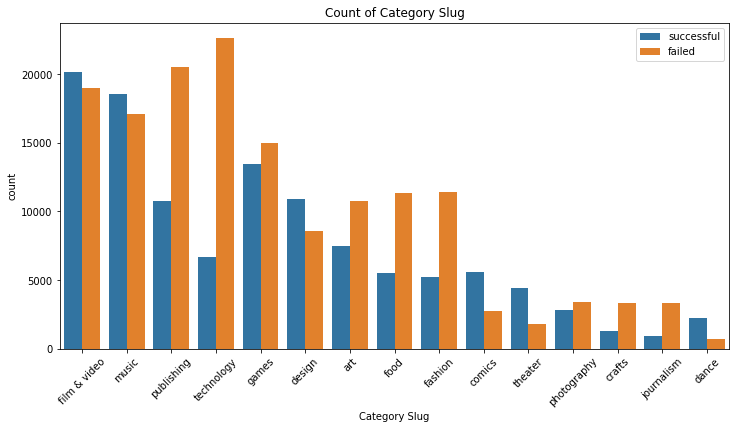

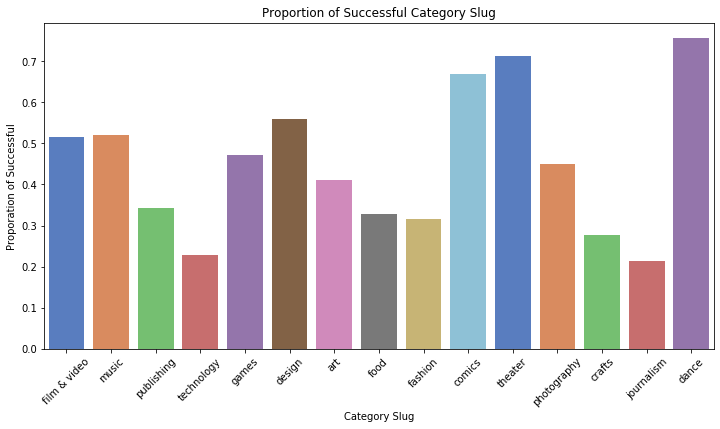

In [210]:
fig = plt.figure(figsize = (12, 6))
chart = sns.countplot(x = 'category_slug', hue = 'binary_state', data = cleaned_data, order=cleaned_data.category_slug.value_counts().index)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.legend(title ='')
plt.xlabel('Category Slug')
plt.title("Count of Category Slug")
plt.show()

#probability distribution
y = (cleaned_data['category_slug'].loc[cleaned_data['binary_state'] == 'successful'].value_counts())/(cleaned_data['category_slug'].value_counts())
y = y.sort_values(ascending = False)
fig=plt.figure(figsize=(12,6))
ax = sns.barplot(x = y.index, y = y, order=cleaned_data.category_slug.value_counts().index, palette = 'muted')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.xlabel('Category Slug')
plt.ylabel('Proporation of Successful')
plt.title('Proportion of Successful Category Slug')
plt.show()

Category slug may be more informative than category name due to too much fragmentation of the data with the numerous category names.

In [211]:
#combining smaller categories into larger one dance, theater_dance and 
cleaned_data["category_slug"].replace({"dance": "theater_dance", "theater": "theater_dance", "journalism" : "publishing"}, inplace=True)
cleaned_data.category_slug.value_counts()

film & video     39110
music            35637
publishing       35474
technology       29291
games            28434
design           19507
art              18304
food             16891
fashion          16650
theater_dance     9186
comics            8347
photography       6255
crafts            4593
Name: category_slug, dtype: int64

In [212]:
#dropping category name due to high number of categories
cleaned_data.drop(columns='category_name', inplace = True)

In [213]:
#too much concentration in town for the data to be useful?
cleaned_data.drop(columns='location_type', inplace = True)

In [214]:
#convert binary state to boolean
d = {'successful': True, 'failed' : False}
cleaned_data['binary_state'] = cleaned_data['binary_state'].map(d)

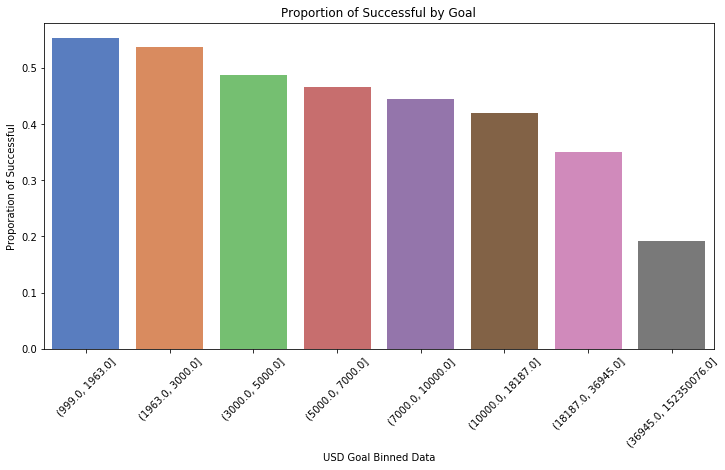

(999.0, 1963.0]          0.55
(1963.0, 3000.0]         0.54
(3000.0, 5000.0]         0.49
(5000.0, 7000.0]         0.47
(7000.0, 10000.0]        0.44
(10000.0, 18187.0]       0.42
(18187.0, 36945.0]       0.35
(36945.0, 152350076.0]   0.19
Name: qcut_goal, dtype: float64


In [215]:
#binning the data to look at probabilities by goal USD
cleaned_data['qcut_goal'] = pd.qcut(cleaned_data['goal_USD'], q=8, precision = 0)
#probability distribution
y = (cleaned_data['qcut_goal'].loc[cleaned_data['binary_state'] == True].value_counts())/(cleaned_data['qcut_goal'].value_counts())
y = y.sort_values(ascending = False)
fig=plt.figure(figsize=(12,6))
ax = sns.barplot(x = y.index, y = y, order=y.index, palette = 'muted')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.xlabel('USD Goal Binned Data')
plt.ylabel('Proporation of Successful')
plt.title('Proportion of Successful by Goal')
plt.show()

print(y)

As expected, probability declines with increasing USD goal amount.

## Correlations

In [216]:
# defining correlation matrix (taken from Kaggle starter code)
def plotCorrelationMatrix(df, graphWidth):
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix', fontsize=15)
    plt.show()

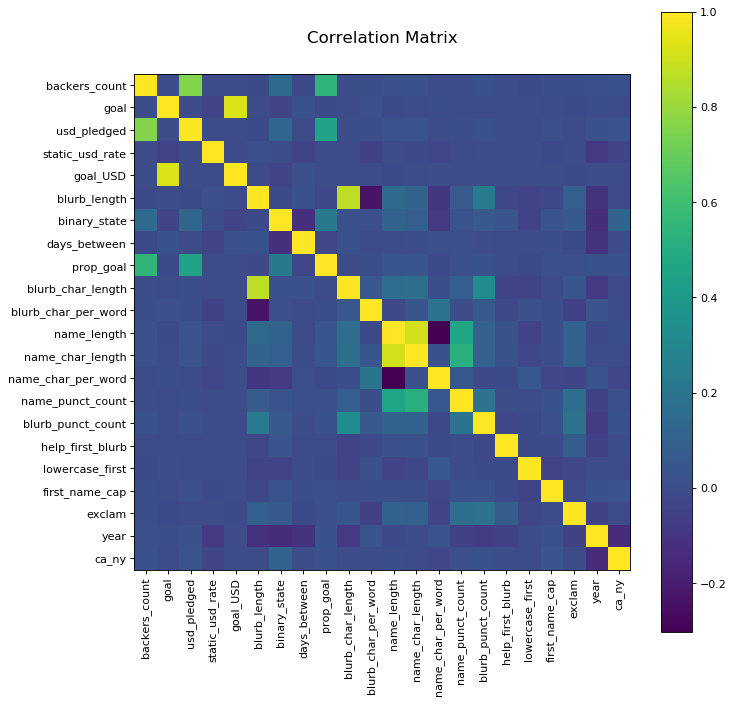

In [217]:
plotCorrelationMatrix(cleaned_data, 10)

There don't appear to be any surprising correlations. Backers count and prop goal should be removed due to correlation with USD pledged. Goal should be removed due to heavy correlation with goal USD. Year has no impact on the future of success. Qcut_goal and cut_static_rate were used for visualization purposes only and will be removed. We are trying to predict success or failure, so USD_pledged is not necessary. Blurb and name are not necessary any more. Deadline is no longer necessary. Currency doesn't seem necessary, but I will also remove static USD rate as it doesn't seem to be impactful, but may consider adding it back and manipulating it in the future. 

Launched at should be kept initially for slicing.

## Modeling

In [218]:
#removing columns while keeping launched at for slicing purposes
cleaned_data.drop(columns=['city', 'location_state', 'location_country', 'currency', 
                           'static_usd_rate', 'backers_count', 'prop_goal', 'goal', 'year', 
                           'qcut_goal', 'usd_pledged', 'blurb', 'name', 'deadline'], inplace = True)

In [219]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267679 entries, 8624 to 2147476221
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   launched_at          267679 non-null  datetime64[ns]
 1   goal_USD             267679 non-null  float64       
 2   category_slug        267679 non-null  object        
 3   blurb_length         267679 non-null  int64         
 4   binary_state         267679 non-null  bool          
 5   days_between         267679 non-null  int64         
 6   blurb_char_length    267679 non-null  int64         
 7   blurb_char_per_word  267679 non-null  float64       
 8   name_length          267679 non-null  int64         
 9   name_char_length     267679 non-null  int64         
 10  name_char_per_word   267679 non-null  float64       
 11  name_punct_count     267679 non-null  int64         
 12  blurb_punct_count    267679 non-null  int64         
 13  help_fi

In [220]:
#converting categorical data to numeric for Light GBM
categorical = ['day_week', 'month', 'category_slug']

for cat in categorical:
    cleaned_data[cat] = cleaned_data[cat].astype('category')
    cleaned_data[cat+'_cat'] = cleaned_data[cat].cat.codes

In [221]:
print(cleaned_data.day_week_cat.head(5))

cleaned_data.drop(columns = ['day_week', 'month', 'category_slug'], inplace = True)

id
8624     4
18520    6
24380    5
33867    1
38736    6
Name: day_week_cat, dtype: int8


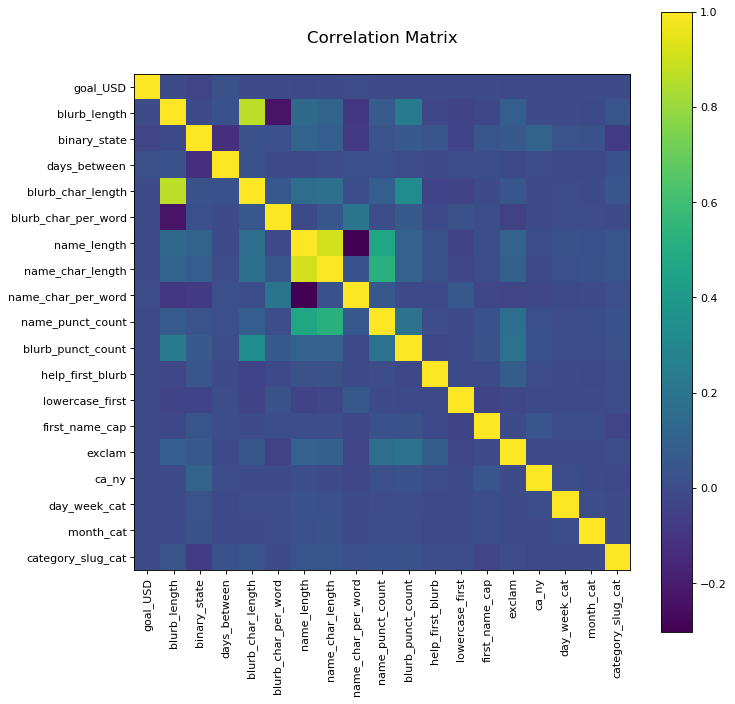

In [222]:
#re-visualizing correlation matrix after dropping columns
plotCorrelationMatrix(cleaned_data, 10)

In [223]:
#slicing data to used late data for test data

#late data to capture the whole last year    
late_data = cleaned_data.loc[cleaned_data.launched_at >= '2018-03-01']
print(len(late_data))

#all other data
train_data = cleaned_data.loc[cleaned_data.launched_at < '2018-03-01']
print(len(train_data))

data_splits = [late_data, train_data]

32838
234841


In [66]:
#removing cleaned data from memory
del cleaned_data

### Random Forest

In [67]:
#splitting everything out again for the first model with all data against the most recent (test) data
test_labels = np.array(data_splits[0]['binary_state'])
test_features = data_splits[0].drop(['binary_state', 'launched_at'], axis=1)
train_labels = np.array(data_splits[1]['binary_state'])
train_features = data_splits[1].drop(['binary_state', 'launched_at'], axis = 1)
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

#feature_list
feature_list = list(train_features.columns)

Training Features Shape: (234841, 18)
Training Labels Shape: (234841,)
Testing Features Shape: (32838, 18)
Testing Labels Shape: (32838,)


In [68]:
#remove data_splits from memory
del data_splits

#### Baseline Model

In [69]:
# Import the RF model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [70]:
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
model.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [71]:
from sklearn.metrics import roc_auc_score, f1_score, log_loss
# Actual class predictions
base_preds = model.predict(test_features)
# Probabilities for each class
base_probs = model.predict_proba(test_features)[:, 1]

base_roc_value = roc_auc_score(test_labels, base_probs)
base_f1_value = f1_score(test_labels, base_preds)
base_log_loss_value = log_loss(test_labels, base_probs, normalize=True)
print("ROC_AUC score:     {:0.4f}".format(base_roc_value))
print("      F-score:     {:0.4f}".format(base_f1_value))
print("     Log Loss:     {:0.4f}".format(base_log_loss_value))

ROC_AUC score:     0.7114
      F-score:     0.5875
     Log Loss:     0.6176


#### Hyperparameter Tuning

In [123]:
# Number of trees in random forest
n_estimators = list(range(160, 204, 4))
# Number of features to consider at every split
max_features = [6, 7]
# Maximum number of levels in tree
max_depth = list(range(50, 72, 2))
# Minimum number of samples required to split a node
min_samples_split = [4, 5, 6, 7]
# Minimum number of samples required at each leaf node
min_samples_leaf = [10, 11, 12, 13]


# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [124]:
rf = RandomForestClassifier(bootstrap=True)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 16, cv = 4, verbose=2, random_state=38, n_jobs = -1, scoring = 'roc_auc')
rf_random.fit(train_features, train_labels)

Fitting 4 folds for each of 16 candidates, totalling 64 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed: 36.8min finished


RandomizedSearchCV(cv=4, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [77]:
#empty list of parameters
rf_param_list = []

In [125]:
#appending best parameters to list
rf_param_list.append(rf_random.best_params_)
for param in rf_param_list:
    print(param)

{'n_estimators': 130, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 4, 'max_depth': 40}
{'n_estimators': 170, 'min_samples_split': 5, 'min_samples_leaf': 12, 'max_features': 4, 'max_depth': 50}
{'n_estimators': 165, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': 6, 'max_depth': 50}
{'n_estimators': 195, 'min_samples_split': 6, 'min_samples_leaf': 12, 'max_features': 7, 'max_depth': 54, 'bootstrap': True}
{'n_estimators': 170, 'min_samples_split': 3, 'min_samples_leaf': 10, 'max_features': 7, 'max_depth': 62, 'bootstrap': True}
{'n_estimators': 190, 'min_samples_split': 6, 'min_samples_leaf': 12, 'max_features': 6, 'max_depth': 68}
{'n_estimators': 168, 'min_samples_split': 5, 'min_samples_leaf': 13, 'max_features': 7, 'max_depth': 64}


In [126]:
# Actual class predictions
rf_predictions = rf_random.predict(test_features)
# Probabilities for each class
rf_probs = rf_random.predict_proba(test_features)[:, 1]
rf_predict = rf_random.predict(test_features)

In [127]:
#change the float display for modeling
pd.options.display.float_format = "{:.4f}".format
from sklearn.metrics import roc_auc_score, f1_score, log_loss


# Calculate roc auc
rf_roc_value = roc_auc_score(test_labels, rf_probs)
rf_f1_value = f1_score(test_labels, rf_predict)
rf_log_loss_value = log_loss(test_labels, rf_probs, normalize=True)
print("ROC_AUC score:     {:0.4f}".format(rf_roc_value))
print("      F-score:     {:0.4f}".format(rf_f1_value))
print("     Log Loss:     {:0.4f}".format(rf_log_loss_value))

ROC_AUC score:     0.7226
      F-score:     0.6049
     Log Loss:     0.6091


In [81]:
#empty list of scores
rf_scores = []

In [128]:
rf_scores.append([rf_roc_value, rf_f1_value, rf_log_loss_value])
for i in rf_scores:
    print(i)

[0.7200494005154532, 0.5999785721938502, 0.6113425918486306]
[0.7215970263652586, 0.5998140333309493, 0.6106025924734105]
[0.7223003579395475, 0.6038406827880513, 0.6095632543282256]
[0.7230677149422042, 0.6057337496451888, 0.6087147998276324]
[0.7220117358475816, 0.6029772267026682, 0.6096603754910155]
[0.7225239243432208, 0.6028993746446845, 0.6091965543649344]
[0.7226345354377517, 0.6048507198071058, 0.6090899542091286]


In [129]:
#best parameters from above
rf = RandomForestClassifier(bootstrap = True, random_state=670, n_estimators=195, min_samples_split=6, min_samples_leaf=12, 
                            max_features=7, max_depth=54)
rf.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=54, max_features=7, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=12, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, n_estimators=195,
                       n_jobs=None, oob_score=False, random_state=670,
                       verbose=0, warm_start=False)

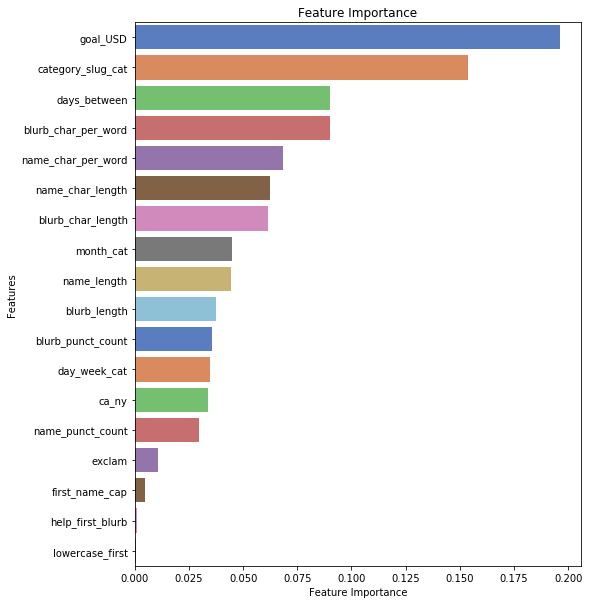

In [130]:
#displaying the most important features
fi_rf = pd.DataFrame({'feature': feature_list,
                   'importance': rf.feature_importances_}).\
                    sort_values('importance', ascending = False)

fig=plt.figure(figsize=(8,10))
ax = sns.barplot(x = 'importance', y = 'feature', data = fi_rf, palette = 'muted')

plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

### Light GBM

#### Baseline Model

In [375]:
import lightgbm as lgb

model = lgb.LGBMModel()
model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [376]:
#creating lgb Datasets
train_set_lgb = lgb.Dataset(data = train_features, label = train_labels, categorical_feature = ['day_week_cat', 'month_cat', 'category_slug_cat'], free_raw_data = False)
test_set_lgb = lgb.Dataset(data = test_features, label = test_labels, categorical_feature = ['day_week_cat', 'month_cat', 'category_slug_cat'], free_raw_data = False)

In [415]:
lgb_baseline = lgb.LGBMClassifier()
default_params = lgb_baseline.get_params()

cv_results = lgb.cv(params = default_params, train_set = train_set_lgb, early_stopping_rounds = 50,
                    metrics = 'auc', nfold = 4, seed = 234)

In [416]:
print('The maximum validation ROC AUC was: {:.4f} with a standard deviation of {:.4f}.'.format(cv_results['auc-mean'][-1], cv_results['auc-stdv'][-1]))
print('The optimal number of boosting rounds (estimators) was {}.'.format(len(cv_results['auc-mean'])))

The maximum validation ROC AUC was: 0.7600 with a standard deviation of 0.0010.
The optimal number of boosting rounds (estimators) was 100.


In [417]:
# Optimal number of esimators found in cv
from sklearn.metrics import roc_auc_score, f1_score, log_loss
lgb_baseline.n_estimators = len(cv_results['auc-mean'])

# Train and make predicions with model
lgb_baseline.fit(train_features, train_labels)
lgb_probs = lgb_baseline.predict_proba(test_features)[:, 1]
lgb_preds = lgb_baseline.predict(test_features)

lgb_base_roc_value = roc_auc_score(test_labels, lgb_probs)
lgb_base_f1_value = f1_score(test_labels, lgb_preds)
lgb_base_log_loss_value = log_loss(test_labels, lgb_probs, normalize=True)
print("ROC_AUC score:     {:0.4f}".format(lgb_base_roc_value))
print("      F-score:     {:0.4f}".format(lgb_base_f1_value))
print("     Log Loss:     {:0.4f}".format(lgb_base_log_loss_value))

ROC_AUC score:     0.7372
      F-score:     0.6199
     Log Loss:     0.5978


#### Hyperparameter Tuning

In [381]:
# Hyperparameter grid
lgb_param_grid = {
    'num_leaves': list(range(40, 51)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.2), base = 10, num = 100)),
    'subsample_for_bin': list(range(50000, 80000, 2000)),
    'min_child_samples': list(range(220, 500, 10)),
    'reg_alpha': list(np.linspace(0.40, 0.95, 56)),
    'reg_lambda': list(np.linspace(0.25, 0.55, 31)),
    'colsample_bytree': list(np.linspace(0.55, 0.75, 21)),
    'subsample': list(np.linspace(0.5, 1.00, 51)),
    'is_unbalance' : [True]
    }
#is unbalance being True significantly improves F1 score ~ 0.04

In [382]:
#CLEARS BEST PARAM LIST
best_param_lgb = []

In [383]:
def objective(hyperparameters, iteration):
    """Objective function for grid and random search. Returns
       the cross validation score from a set of hyperparameters."""
    
    # Number of estimators will be found using early stopping
    if 'n_estimators' in hyperparameters.keys():
        del hyperparameters['n_estimators']
    
     # Perform n_folds cross validation
    cv_results = lgb.cv(hyperparameters, train_set_lgb, num_boost_round = 50000, nfold = 4, 
                        early_stopping_rounds = 50, metrics = 'auc', seed = 157)
    
    # results to retun
    score = cv_results['auc-mean'][-1]
    estimators = len(cv_results['auc-mean'])
    hyperparameters['n_estimators'] = estimators 
    
    return [score, hyperparameters, iteration]

In [384]:
#defining random search function
import random
def random_search(param_grid, max_evals = 25):
    """Random search for hyperparameter optimization"""
    
    # Dataframe for results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                                  index = list(range(max_evals)))
    
    # Keep searching until reach max evaluations
    for i in range(max_evals):
        
        # Choose random hyperparameters
        hyperparameters = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
        
        # Evaluate randomly selected hyperparameters
        eval_results = objective(hyperparameters, i)
        
        results.loc[i, :] = eval_results
    
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    return results

In [385]:
#custom random search

random_results = random_search(lgb_param_grid, 25)

print('The best validation score was {:.5f}'.format(random_results.loc[0, 'score']))

The best validation score was 0.76370


In [393]:
#best_param_lgb.append(random_results.loc[0, 'params'])
for param in best_param_lgb:
    print(param)

{'num_leaves': 42, 'learning_rate': 0.004999999999999999, 'subsample_for_bin': 62000, 'min_child_samples': 300, 'reg_alpha': 0.73, 'reg_lambda': 0.32, 'colsample_bytree': 0.71, 'subsample': 0.66, 'is_unbalance': True, 'n_estimators': 5866}
{'num_leaves': 48, 'learning_rate': 0.00538684962932972, 'subsample_for_bin': 58000, 'min_child_samples': 340, 'reg_alpha': 0.84, 'reg_lambda': 0.45000000000000007, 'colsample_bytree': 0.5800000000000001, 'subsample': 0.65, 'is_unbalance': True, 'n_estimators': 5263}


In [396]:
# Train model
lgb_model = lgb.LGBMClassifier(num_leaves = best_param_lgb[-1]['num_leaves'], learning_rate = best_param_lgb[-1]['learning_rate'], 
                               subsample_for_bin = best_param_lgb[-1]['subsample_for_bin'], min_child_samples = best_param_lgb[-1]['min_child_samples'], 
                               reg_alpha = best_param_lgb[-1]['reg_alpha'], reg_lambda = best_param_lgb[-1]['reg_lambda'], 
                               colsample_bytree = best_param_lgb[-1]['colsample_bytree'], subsample = best_param_lgb[-1]['subsample'], 
                               is_unbalance = True, n_estimators = best_param_lgb[-1]['n_estimators'], random_state = 126)
lgb_model.fit(train_features, train_labels)

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.5800000000000001, importance_type='split',
               is_unbalance=True, learning_rate=0.00538684962932972,
               max_depth=-1, min_child_samples=340, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=5263, n_jobs=-1, num_leaves=48,
               objective=None, random_state=126, reg_alpha=0.84,
               reg_lambda=0.45000000000000007, silent=True, subsample=0.65,
               subsample_for_bin=58000, subsample_freq=0)

In [397]:
# Actual class predictions
lgb_preds = lgb_model.predict(test_features)
# Probabilities for each class
lgb_probs = lgb_model.predict_proba(test_features)[:, 1]

In [398]:
# Calculate roc auc
lgb_roc_value = roc_auc_score(test_labels, lgb_probs)
lgb_f1_value = f1_score(test_labels, lgb_preds)
lgb_log_loss_value = log_loss(test_labels, lgb_probs, normalize=True)
print("ROC_AUC score:     {:0.4f}".format(lgb_roc_value))
print("      F-score:     {:0.4f}".format(lgb_f1_value))
print("     Log Loss:     {:0.4f}".format(lgb_log_loss_value))

ROC_AUC score:     0.7426
      F-score:     0.6655
     Log Loss:     0.5954


In [390]:
#empty list of scores
lgb_scores = []

In [399]:
lgb_scores.append([lgb_roc_value, lgb_f1_value, lgb_log_loss_value])
for i in lgb_scores:
    print(i)

[0.7420907552160241, 0.6658540396937022, 0.5958938354386207]
[0.7425774074502671, 0.665457388584832, 0.5953690581289043]


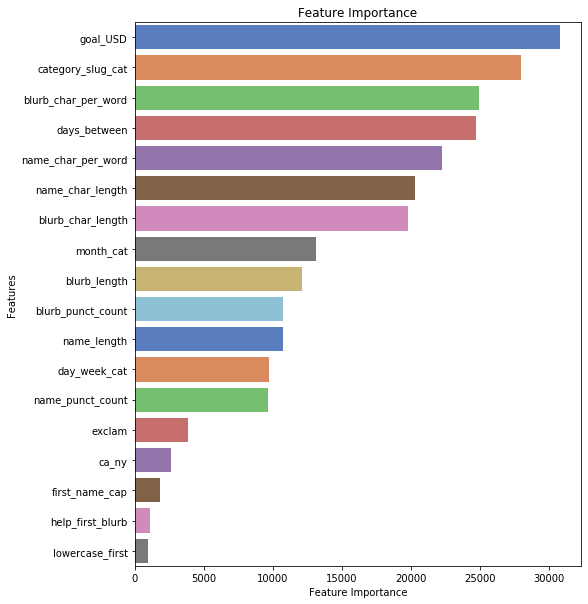

In [400]:
#displaying the most important features
fi_lgb = pd.DataFrame({'feature': feature_list,
                   'importance': lgb_model.feature_importances_}).\
                    sort_values('importance', ascending = False)

fig=plt.figure(figsize=(8,10))
ax = sns.barplot(x = 'importance', y = 'feature', data = fi_lgb, palette = 'muted')

plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

## Model Comparison

In [142]:
#convert scores to a df
score_data = [{'baseline_RF' : 0.7114, 'tuned_RF' : 0.7231, 'baseline_LGBM' : 0.7372, 'tuned_LGBM' : 0.7426},  
              {'baseline_RF': 0.5875, 'tuned_RF' : 0.6057, 'baseline_LGBM' : 0.6199, 'tuned_LGBM' : 0.6655}, 
              {'baseline_RF' : 0.6176, 'tuned_RF' : 0.6087, 'baseline_LGBM': 0.5978, 'tuned_LGBM' : 0.5954}]

In [144]:
score_df = pd.DataFrame(score_data, index = ['roc_auc', 'f1_score', 'log_loss'])

In [146]:
score_df = score_df.reset_index().melt(id_vars=["index"])
print(score_df)

       index       variable  value
0    roc_auc    baseline_RF 0.7114
1   f1_score    baseline_RF 0.5875
2   log_loss    baseline_RF 0.6176
3    roc_auc       tuned_RF 0.7231
4   f1_score       tuned_RF 0.6057
5   log_loss       tuned_RF 0.6087
6    roc_auc  baseline_LGBM 0.7372
7   f1_score  baseline_LGBM 0.6199
8   log_loss  baseline_LGBM 0.5978
9    roc_auc     tuned_LGBM 0.7426
10  f1_score     tuned_LGBM 0.6655
11  log_loss     tuned_LGBM 0.5954


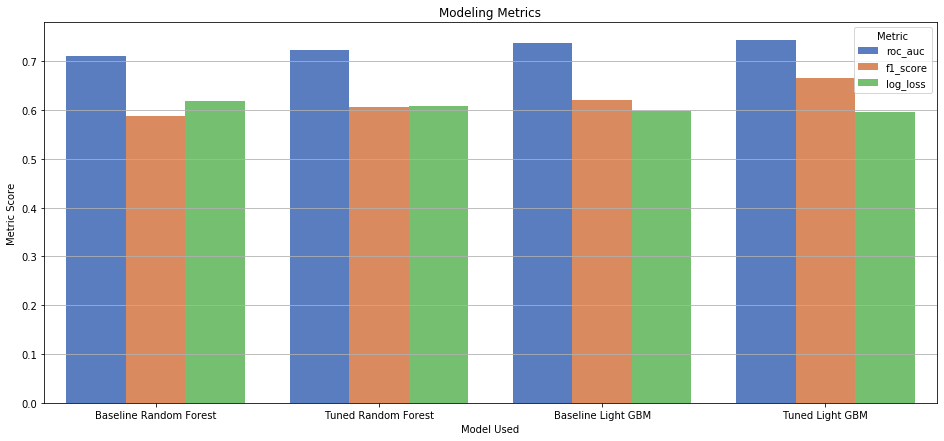

In [158]:
f, ax = plt.subplots(figsize = (16,7))
sns.barplot(x = 'variable', y = 'value', hue = 'index', data = score_df,
            palette = 'muted')
plt.grid(axis='y')
plt.xlabel('Model Used')
plt.ylabel('Metric Score')
plt.title('Modeling Metrics')
plt.legend(title = 'Metric')
ax.set_xticklabels(["Baseline Random Forest", "Tuned Random Forest", "Baseline Light GBM", "Tuned Light GBM"])
plt.show()